In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
import seaborn as sns
sns.set_style('darkgrid')

from minisom import MiniSom   

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import classification_report

from tqdm.notebook import trange, tqdm
random_state = 42

# Read data

In [2]:
# Data
df_train = pd.read_csv('./resources/14cancer.xtrain', 
                      delim_whitespace=True, names=[f'sample {i}' for i in range(1, 145)])
df_test = pd.read_csv('./resources/14cancer.xtest', 
                     delim_whitespace=True, names=[f'sample {i}' for i in range(1, 55)])
df_train = df_train.T.reset_index().drop(columns='index').copy()
df_test = df_test.T.reset_index().drop(columns='index').copy()

# Labels
labels = [int(x) for x in open('./resources/14cancer.ytrain').readline().split()]
df_labels_train = pd.DataFrame({'label': labels})
labelstest = [int(x) for x in open('./resources/14cancer.ytest').readline().split()]
df_labels_test = pd.DataFrame({'label': labelstest})

print(f'Training data X:{df_train.shape}, y:{df_labels_train.shape}')
print(f'Testing data X:{df_test.shape}, y:{df_labels_test.shape}')

Training data X:(144, 16063), y:(144, 1)
Testing data X:(54, 16063), y:(54, 1)


In [3]:
label_names = {
    1: 'breast',
    2:  'prostate',
    3:  'lung',
    4:  'collerectal',
    5:  'lymphoma',
    6:  'bladder',
    7:  'melanoma',
    8:  'uterus',
    9: 'leukemia',
    10: 'renal',
    11: 'pancreas',
    12: 'ovary',
    13: 'meso',
    14: 'cns'
}

**Normalise data**

In [4]:
X_train = StandardScaler().fit_transform(df_train)
X_test = StandardScaler().fit_transform(df_test)
y_train = df_labels_train['label'].values
y_test = df_labels_test['label'].values

# Self-Organising Maps (SOM)


In [5]:
# Hyper-parameters
params = {
    'n_feats':X_train.shape[1],
    'shape':(26,26),
    'sigma':10,
    'l_r':1.0,
    'num_iter':1000,
    'seed':10,
}

In [6]:
# Train
som = MiniSom(params['shape'][0], params['shape'][1], params['n_feats'], sigma=params['sigma'],
                      learning_rate=params['l_r'], random_seed=params['seed']) 
# som.pca_weights_init(X_train)
som.train(X_train, params['num_iter'], verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 82.76154851087254


In [7]:
def classify(som, x, y):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(x, y)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in x:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [8]:
pred = classify(som, X_test, y_test)

print(adjusted_mutual_info_score(df_labels_test.label, pred))
print(classification_report(df_labels_test.label, pred))

0.8997517369145184
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       0.86      1.00      0.92         6
           6       0.75      1.00      0.86         3
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         4
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00         4

    accuracy                           0.94        54
   macro avg       0.96      0.93      0.93        54
weighted avg       0.95      0.94      0.94        54



## 2.1.1 Plot the weights of the map

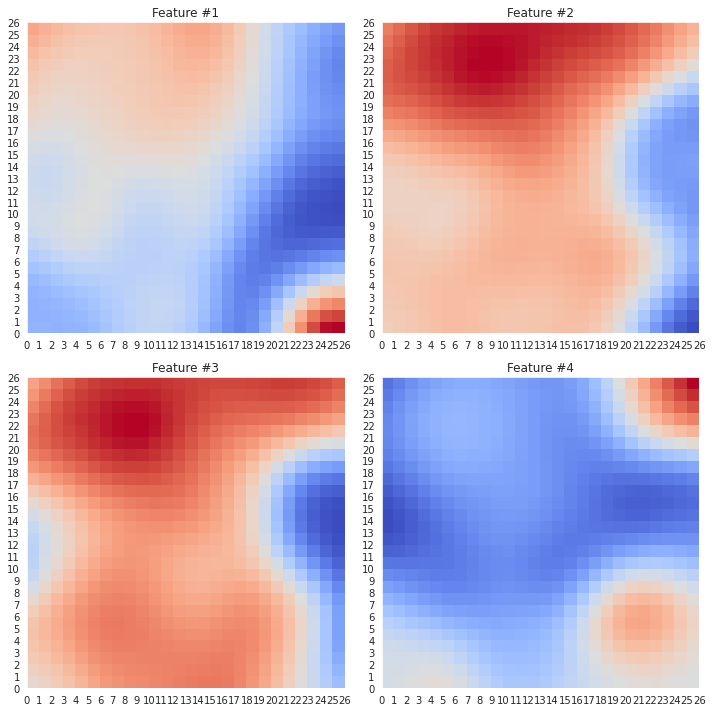

In [9]:
# Examples of the first 4 weights
size = params['shape'][0]
W = som.get_weights()
fig = plt.figure(figsize=(10, 10))

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.pcolor(W[:,:,i].T, cmap='coolwarm')
    ax.set_title(f'Feature #{i+1}')
    ax.set_xticks(np.arange(size+1))
    ax.set_yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

## 2.1.2 Plot the U-Matrix

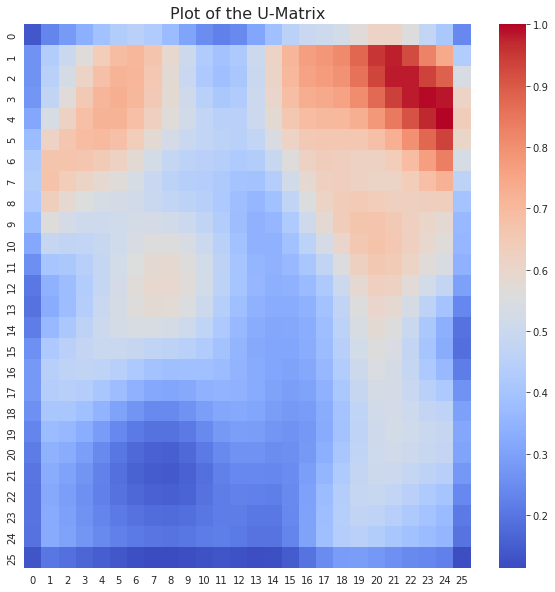

In [10]:
# Plot the distance_map from the som to get the U-Matrix (NxN)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax = sns.heatmap(som.distance_map().T,cmap='coolwarm')
ax.set_title('Plot of the U-Matrix',fontsize=16)
plt.show()

## 2.1.3 Plot the clusters

In [11]:
w_x, w_y = zip(*[som.winner(d) for d in X_train])
w_x = np.array(w_x)
w_y = np.array(w_y)

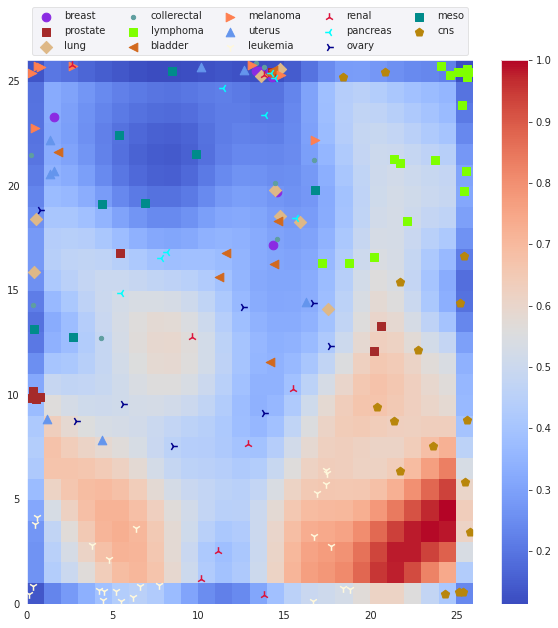

In [13]:
# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plt.pcolor(som.distance_map().T, cmap='coolwarm',)
plt.colorbar()

markers = ['o', 's', 'D', '.', ',', '<', '>', '^', '1', '2', '3', '4', 's', 'p', 'P', '*']
colors = ['blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 
          'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', ]

for clust in np.unique(y_train):
    idx_target = y_train==clust
    ax.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=75, c=colors[clust-1],facecolor='none', label=label_names[clust],
               marker=markers[clust-1])
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand",ncol=5,framealpha=0.5)
plt.grid()
plt.show()

## 2.1.3 Discussion of results

Some small clusters can found such as leukemia clusters at the bottom left and bottom centre of the plot. There is also a lymphoma cluster at the top right corner of the plot.

There is no distinct clusters in the plot. But at the top centre there is a cluster of melanoma, uterus, collerectal, breast and pancreas cancers. A similar cluster occurs in the centre.